# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [2]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [3]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [4]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [26]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = np.logspace(-9, -5, 8)
regularization_strengths =np.logspace(3, 7, 8)

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

num_iters = [300, 1500]

for lr_i in learning_rates:
    for reg_i in regularization_strengths:
        svm_val = LinearSVM()
        loss_hist = svm_val.train(X_train_feats, y_train, learning_rate=lr_i, reg=reg_i,
                          num_iters=num_iters[1], verbose=False)
        
        y_train_pred = svm_val.predict(X_train_feats)
        y_val_pred = svm_val.predict(X_val_feats)
        
        curr_accuracy_train = np.mean(y_train == y_train_pred)
        curr_accuracy_val = np.mean(y_val == y_val_pred)
        print(f'learning rate: {lr_i}, reg: {reg_i}')
        print(f'train accuracy: {curr_accuracy_train}, validation accuracy: {curr_accuracy_val}')
        
        results[lr_i, reg_i] = [curr_accuracy_train, curr_accuracy_val]
        
        if curr_accuracy_val > best_val:
            best_val = curr_accuracy_val
            best_svm = svm_val

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

learning rate: 1e-09, reg: 1000.0
train accuracy: 0.09736734693877551, validation accuracy: 0.108
learning rate: 1e-09, reg: 3727.593720314938
train accuracy: 0.11175510204081633, validation accuracy: 0.11
learning rate: 1e-09, reg: 13894.95494373136
train accuracy: 0.11057142857142857, validation accuracy: 0.112
learning rate: 1e-09, reg: 51794.74679231213
train accuracy: 0.1123469387755102, validation accuracy: 0.112
learning rate: 1e-09, reg: 193069.77288832495
train accuracy: 0.09859183673469388, validation accuracy: 0.108
learning rate: 1e-09, reg: 719685.6730011514
train accuracy: 0.10955102040816327, validation accuracy: 0.123
learning rate: 1e-09, reg: 2682695.7952797273
train accuracy: 0.18283673469387754, validation accuracy: 0.168
learning rate: 1e-09, reg: 10000000.0
train accuracy: 0.4171020408163265, validation accuracy: 0.415
learning rate: 3.727593720314938e-09, reg: 1000.0
train accuracy: 0.10318367346938775, validation accuracy: 0.108
learning rate: 3.727593720314938e

In [27]:
# Evaluate your trained SVM on the test set: you should be able to get at least 0.40
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.419


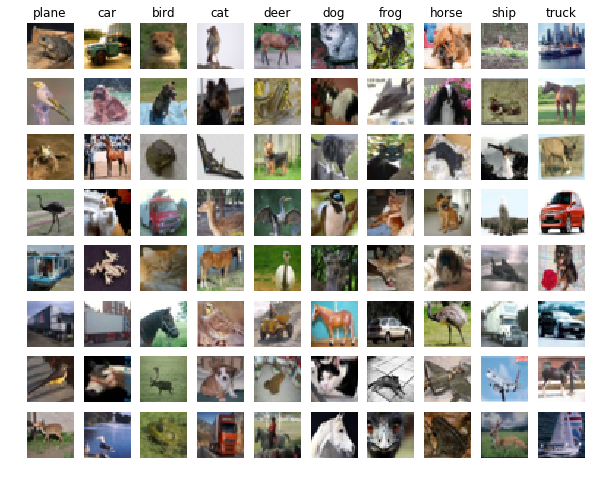

In [28]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$
- Yes, the misclassification results generally make sense. We see similar classes of objects being identified as each other.
- For example, we see cars being identified as trucks and trucks being identified as cars. This happens as the shapes (captured by the HOG) and colours (captured by the colour histogram) of the vehicles are similar and low resolution, which leads them to being misidentified for each other. These represent challenges of occlusion and intra-class variation being faced by the model. 
- Other examples include horses identified as deer, and dogs being identified as horses, where generally similar looking animals are being misidentified as the wrong class due to having similar shapes, colours, or backgrounds (grass/greenery). This represents challenges including viewpoint variation, occlusion, background clutter, and intra-class variation, being faced by the model.
- Overall, this indicates that our dataset of features derived from HOG and the colour histogram was not sufficient for our model to distinguish between our image classes with high accuracy. In other words, this suggests an issue with either our dataset of features derived from HOG and the colour histogram, or our choice of SVM model, or a combination of both.

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [5]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [13]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# num_training = 49000, batch_size= 200, 49000/200 ~= 250 iters/epoch

# Coarse (Random) Search 
# - First, LR was prioritised. LR was narrowed from [10^-9 to 10^0] to [10^-1 to 10^0] with 1 epoch (250 iters).
# - Next, reg strength was tuned. Reg range was narrowed from [10^-9 to 10^9] to [10^-8 to 10^-3] with 1 epoch (250 iters).
# - Finally, hidden size was tuned. Size range was narrowed from [1 to 500] to [100 to 200] with 1 epoch (250 iters). Initial range was kept narrow due to computation times with large networks.

# Fine (Random) Search
# - Using higher number of epochs (500) to do a finer search to narrow down the parameter ranges further.
# - First, LR was narrowed from [10^-1 to 10^0] to [7e-2 to 1e-1].
# - Next, Reg strength was narrowed from [10^-8 to 10^-3] to [1e-7 to 1e-5].
# - Last, hidden size was narrowed from [100 to 200] to [100 to 150].

# Hyperparameters to tune - Coarse Search
# learning_rates = np.logspace(-9, 0, 10)
# regularization_strengths = np.logspace(-9, 9, 20)
# hidden_sizes = np.linspace(1, 500, 10, dtype=int)
# num_iters = [250]

# Hyperparameters to tune - Fine Search
# learning_rates = np.linspace(1e-1, 0, 10)
# regularization_strengths = np.logspace(-8, -3, 15)
# hidden_sizes = np.linspace(100, 200, 10, dtype=int)
# num_iters = [500]

# Hyperparameters to tune - Final search
learning_rates = np.linspace(7e-2, 1e-1, 6)
regularization_strengths = np.linspace(1e-7, 1e-5, 10)
hidden_sizes = np.linspace(100, 150, 6, dtype=int)
num_iters = [1500, 5000]

# Other variables
search_iters = 10
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.

for i in range(search_iters):
    # Randomly select parameter values
    lr_rand = np.random.choice(learning_rates, 1)[0]
    reg_rand = np.random.choice(regularization_strengths, 1)[0]
    size_rand = np.random.choice(hidden_sizes, 1)[0]
    epochs = np.random.choice(num_iters, 1)[0]
    print(f'Search attempt: {i+1} | lr: {lr_rand} | reg: {reg_rand} | size: {size_rand} | iters: {epochs}')

    # Initialise and train the network using these values
    net = TwoLayerNet(input_dim, hidden_dim, num_classes)
    stats_rand = net.train(X_train_feats, y_train, X_val_feats, y_val,
                num_iters=epochs, batch_size=200,
                learning_rate=lr_rand,
                reg=reg_rand, verbose=False)

    # Compute training and validation accuracies
    train_acc_rand = (net.predict(X_train_feats) == y_train).mean()
    val_acc_rand = (net.predict(X_val_feats) == y_val).mean()
    
    results[lr_rand, reg_rand, size_rand] = [train_acc_rand, val_acc_rand]
    
    if val_acc_rand > best_val:
        best_val = val_acc_rand
        best_net = net

# Explore results - ranking by lr
for lr, reg, size in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg, size)]
    print(f'lr: {lr}, reg: {reg}, size: {size}, train acc: {train_accuracy}, val acc:{val_accuracy}')

# Explore results - ranking by reg
# for lr, reg, size in sorted(results, key=lambda x: x[1]):
#     train_accuracy, val_accuracy = results[(lr, reg, size)]
#     print(f'lr: {lr}, reg: {reg}, size: {size}, train acc: {train_accuracy}, val acc:{val_accuracy}')

# Explore results - ranking by size
# for lr, reg, size in sorted(results, key=lambda x: x[2]):
#     train_accuracy, val_accuracy = results[(lr, reg, size)]
#     print(f'lr: {lr}, reg: {reg}, size: {size}, train acc: {train_accuracy}, val acc:{val_accuracy}')
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


Search attempt: 1 | lr: 0.08800000000000001 | reg: 3.4e-06 | size: 140 | iters: 1500
Search attempt: 2 | lr: 0.082 | reg: 2.3e-06 | size: 150 | iters: 5000
Search attempt: 3 | lr: 0.07600000000000001 | reg: 7.800000000000002e-06 | size: 110 | iters: 1500
Search attempt: 4 | lr: 0.094 | reg: 1.2e-06 | size: 100 | iters: 1500
Search attempt: 5 | lr: 0.1 | reg: 1e-05 | size: 110 | iters: 5000
Search attempt: 6 | lr: 0.07 | reg: 1.2e-06 | size: 140 | iters: 1500
Search attempt: 7 | lr: 0.08800000000000001 | reg: 1e-07 | size: 110 | iters: 1500
Search attempt: 8 | lr: 0.07600000000000001 | reg: 1e-05 | size: 120 | iters: 5000
Search attempt: 9 | lr: 0.07600000000000001 | reg: 1e-07 | size: 110 | iters: 5000
Search attempt: 10 | lr: 0.07600000000000001 | reg: 6.7e-06 | size: 120 | iters: 5000
lr: 0.07, reg: 1.2e-06, size: 140, train acc: 0.5244489795918368, val acc:0.519
lr: 0.07600000000000001, reg: 1e-07, size: 110, train acc: 0.5988775510204082, val acc:0.569
lr: 0.07600000000000001, reg:

In [14]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.578
